In [1]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(-1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, 1, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [15]:
df = pd.read_csv('a_catalog.csv')
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

#Change the drop procedure from 3 lines to 1
df.drop(['name_s', 'id', 'nuniverse'], axis = 1, inplace = True)

df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nstar,stype,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,0.07928,351.98689,0.02225,0.02225,0.00139,0.00149,1986.80254,0.51902,1823.20348,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,1.871119,21.85221,False,0.0,0.0,-36000.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,0.06438,351.98689,0.40843,0.40843,0.02577,0.02736,5.89796,0.50485,413.89362,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,1.275610,21.85221,False,0.0,0.0,-36000.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,0.01797,351.98689,1.08622,1.08622,0.06861,0.07277,0.83390,0.16952,218.31895,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,True,0.024712,21.85221,False,0.0,0.0,-36000.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,0.09864,0.42148,0.26988,0.26988,0.01687,0.01808,13.50798,0.15915,441.44066,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,3.443921,21.85221,False,0.0,0.0,-36000.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,0.05960,0.42148,0.41766,0.41766,0.01427,0.02798,5.64018,0.87606,389.02824,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,2.827395,21.85221,False,0.0,0.0,-36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,0.07304,0.10537,0.14727,0.14727,0.01173,0.01536,0.22655,0.06440,163.12614,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.072783,100.00000,False,0.0,0.0,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,0.00894,218.62589,0.02683,0.02683,0.00189,0.00280,6.82394,0.04080,401.11076,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,0.681642,100.00000,False,0.0,0.0,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,0.09392,218.62589,0.10867,0.10867,0.00644,0.01134,0.41604,0.84537,183.29836,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.163095,100.00000,False,0.0,0.0,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,0.09322,218.62589,0.35841,0.35841,0.02792,0.03739,0.03825,0.05919,101.05305,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,0.006562,100.00000,False,0.0,0.0,-36000.0


In [9]:
scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

data

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nstar,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew,stype_F,stype_G,stype_K,stype_M
0,2718,28,3,0,2190,2644,13645,1462,1830,3705,15858,5872,234,234,77,50,1066,10382,11215,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,0,36,2633,0,0,0,0,0,1,0,0
1,1486,3797,1,0,2190,15014,1858,11986,4271,15386,12877,5872,5714,5714,1454,1463,3,10099,2366,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,0,24,2633,0,0,0,0,0,1,0,0
2,193,16535,0,0,2190,11429,2884,875,13651,5755,3591,5872,15331,15331,3874,3944,0,3391,1138,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,20000,0,2633,0,0,0,0,0,1,0,0
3,1265,2030,2,0,12811,8351,1504,7189,13289,15696,19731,7,3748,3748,951,956,7,3183,2539,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,0,67,2633,0,0,0,0,0,1,0,0
4,2029,3927,2,0,12811,5466,6513,9489,8082,19697,11920,7,5845,5845,805,1497,3,17525,2210,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,0,55,2633,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,423,1927,1,0,8651,10477,18620,3670,11979,13503,14609,1,2008,2008,661,808,0,1288,791,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,20000,1,20000,0,0,0,0,0,0,0,1
14000,351,131,0,0,13729,5784,7249,19306,9197,2567,1784,3647,299,299,105,121,3,816,2286,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,0,13,20000,0,0,0,0,0,0,0,1
14001,1054,1214,0,0,13729,16156,18961,15478,13697,7089,18787,3647,1460,1460,362,588,0,16911,918,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,20000,3,20000,0,0,0,0,0,0,0,1
14002,1075,7376,0,0,13729,14418,18626,8442,13642,6535,18647,3647,5004,5004,1576,2011,0,1184,402,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,0,0,20000,0,0,0,0,0,0,0,1


In [10]:
min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]

min_max_df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nstar,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew,stype_F,stype_G,stype_K,stype_M
Min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Max,20000,20000,20000,0,19999,19999,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,19999,20000,20000,20000,20000,20000,19999,20000,20000,20000,19999,20000,20000,20000,20000,20000,20000,20000,1,1,1,1


In [31]:
flag = np.random.randint(0, 2, size=data.shape[0])

#Splitting the data into train, test, flag_train and flag_test
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)

#Splitting test data into encoded_test, encoded_cal, flag_test, flag_val
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)


array([1, 0, 1, ..., 1, 0, 1])

In [12]:
#Turning everything into torch tensors

encoded_data_train_tensor = torch.tensor(encoded_data_train.values, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

encoded_data_test_tensor = torch.tensor(encoded_data_test.values, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

encoded_data_val_tensor = torch.tensor(encoded_data_val.values, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

print(encoded_data_train_tensor)
print(flag_train)

tensor([[  304,  3275,     0,  ...,     0,     0,     1],
        [  436,   425,     0,  ...,     0,     1,     0],
        [  378, 10359,     1,  ...,     0,     1,     0],
        ...,
        [ 2407, 11685,     3,  ...,     0,     0,     1],
        [  168,   334,     0,  ...,     1,     0,     0],
        [   53,   315,     0,  ...,     0,     1,     0]])
tensor([1, 1, 1,  ..., 0, 1, 0])


In [13]:
src_vocab_size = scaler_number + 1   #source vocab size - 1 bigger than scale (scale starts at 0 so size max+1)
tgt_vocab_size = 2                   #target vocab size
d_model = 128     # Dimensionality of model
num_heads = 1     # Number of heads
num_layers = 2    # Number of layers
d_ff = 32         # Dimensionality of the FFN
max_seq_length = 48   # Maximum length of a sequence the model can process
dropout = 0.1         # Prevents overfitting by setting random neurons to 0
epoch_num = 30        # How many times to optimize

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
val_losses = []
test_losses = []

transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train_tensor, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val_tensor, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test_tensor, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

Epoch: 1, Loss: 0.7982638478279114
Epoch: 2, Loss: 0.757504940032959
Epoch: 3, Loss: 0.7178648114204407
Epoch: 4, Loss: 0.6823819875717163
Epoch: 5, Loss: 0.6499183177947998
Epoch: 6, Loss: 0.6187343597412109
Epoch: 7, Loss: 0.5888679623603821
Epoch: 8, Loss: 0.5568289160728455
Epoch: 9, Loss: 0.5299383997917175
Epoch: 10, Loss: 0.5036357641220093
Validation Loss: 0.4502732455730438
Epoch: 11, Loss: 0.4766155481338501
Epoch: 12, Loss: 0.4509277939796448
Epoch: 13, Loss: 0.42639675736427307
Epoch: 14, Loss: 0.4025229215621948
Epoch: 15, Loss: 0.3797318637371063
Epoch: 16, Loss: 0.35731810331344604
Epoch: 17, Loss: 0.33718329668045044
Epoch: 18, Loss: 0.31667667627334595
Epoch: 19, Loss: 0.29740020632743835
Epoch: 20, Loss: 0.2809010446071625
Validation Loss: 0.22868579626083374
Epoch: 21, Loss: 0.2614593803882599
Epoch: 22, Loss: 0.2452114075422287
Epoch: 23, Loss: 0.2290375828742981
Epoch: 24, Loss: 0.21424166858196259
Epoch: 25, Loss: 0.20118671655654907
Epoch: 26, Loss: 0.18738448619

Text(0, 0.5, 'Loss')

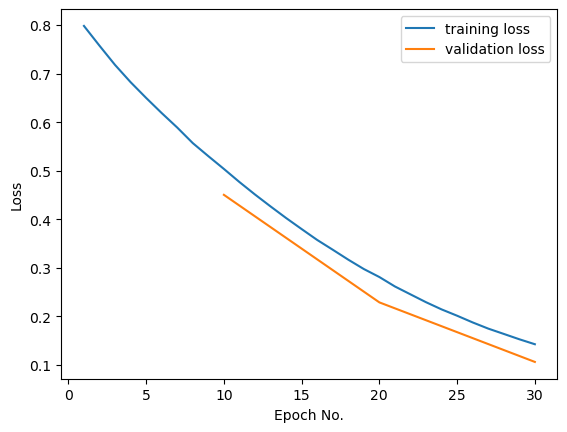

In [20]:
#plot loss as a function of epoch

epoch_range=np.arange(1,epoch_num + 1)

plt.plot(epoch_range, train_losses, label = 'training loss')
plt.plot(epoch_range[epoch_range % 10 == 0], val_losses, label = 'validation loss')

plt.legend()
plt.xlabel('Epoch No.')
plt.ylabel('Loss')

In [28]:
# Convert output to probabilities and get predictions
test_probs = torch.sigmoid(test_output) #converts output by model into probabilities
test_preds = torch.argmax(test_probs, dim=-1).squeeze() 

# Calculate metrics
accuracy = metrics.accuracy_score(flag_test, test_preds)
precision = metrics.precision_score(flag_test, test_preds)
recall = metrics.recall_score(flag_test, test_preds)
f1_score = metrics.f1_score(flag_test, test_preds)
# harmonic mean of precision and recall (1=best, 0=worst)

tensor([0, 1, 0,  ..., 1, 0, 0])


In [24]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Text(0.5, 1.0, 'CONFUSION MATRIX')

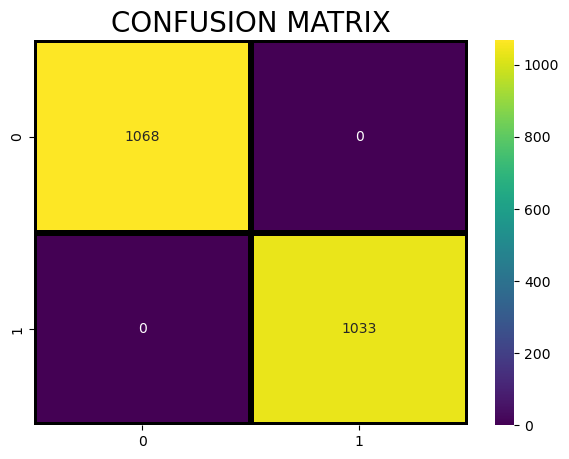

In [25]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(flag_test, test_preds),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

# Let's Attempt to do the same with my LifeSIM data

# Let's try to predict the actual habitability of a planet instead of a syntetic label!!!

In [58]:
#loading LIFEsim dataset
df = pd.read_csv('sim_catalog', index_col=0)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

flag = np.array(df['habitable'].astype('int'))                      #We will attempt to predict habitability instead of synthetic label so we need it in a binary form

df.drop(['name_s', 'id', 'nuniverse', 'habitable'], axis = 1, inplace = True)

df

,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nstar,stype,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,snr_1h,baseline,detected,snr_current,int_time,t_slew
radius_p,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,0.07928,351.98689,0.02225,0.02225,0.00139,0.00149,1986.80254,0.51902,1823.20348,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,3.747645,21.85221,True,11.808785,35743.408285,0.0
1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,0.06438,351.98689,0.40843,0.40843,0.02577,0.02736,5.89796,0.50485,413.89362,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,2.570891,21.85221,True,8.100845,35743.408285,0.0
0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,0.01797,351.98689,1.08622,1.08622,0.06861,0.07277,0.83390,0.16952,218.31895,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,0.051327,21.85221,False,0.161731,35743.408285,0.0
1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,0.09864,0.42148,0.26988,0.26988,0.01687,0.01808,13.50798,0.15915,441.44066,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,8.482665,21.85221,True,26.728775,35743.408285,0.0
2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,0.05960,0.42148,0.41766,0.41766,0.01427,0.02798,5.64018,0.87606,389.02824,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,G,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,7.213424,21.85221,True,22.729412,35743.408285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,0.07304,0.10537,0.14727,0.14727,0.01173,0.01536,0.22655,0.06440,163.12614,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,0.286335,100.00000,False,0.000000,0.000000,-36000.0
0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,0.00894,218.62589,0.02683,0.02683,0.00189,0.00280,6.82394,0.04080,401.11076,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,1.669327,100.00000,False,0.000000,0.000000,-36000.0
1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,0.09392,218.62589,0.10867,0.10867,0.00644,0.01134,0.41604,0.84537,183.29836,0.243,0.18,3100.0,9.58606,306.52209,58.57297,1718,M,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,0.552908,100.00000,False,0.000000,0.000000,-36000.0


In [59]:
scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

data

,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nstar,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,snr_1h,baseline,detected,snr_current,int_time,t_slew,stype_F,stype_G,stype_K,stype_M
0,28,3,0,2190,2644,13645,1462,1830,3705,15858,5872,234,234,77,50,1066,10382,11215,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,33,2633,20000,33,946,20000,0,1,0,0
1,3797,1,0,2190,15014,1858,11986,4271,15386,12877,5872,5714,5714,1454,1463,3,10099,2366,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,23,2633,20000,22,946,20000,0,1,0,0
2,16535,0,0,2190,11429,2884,875,13651,5755,3591,5872,15331,15331,3874,3944,0,3391,1138,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,0,2633,0,0,946,20000,0,1,0,0
3,2030,2,0,12811,8351,1504,7189,13289,15696,19731,7,3748,3748,951,956,7,3183,2539,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,76,2633,20000,75,946,20000,0,1,0,0
4,3927,2,0,12811,5466,6513,9489,8082,19697,11920,7,5845,5845,805,1497,3,17525,2210,10747,12195,13877,14487,8311,13692,0,7847,11889,11710,11953,2507,7381,7809,7675,65,2633,20000,63,946,20000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,1927,1,0,8651,10477,18620,3670,11979,13503,14609,1,2008,2008,661,808,0,1288,791,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,2,20000,0,0,0,0,0,0,0,1
14000,131,0,0,13729,5784,7249,19306,9197,2567,1784,3647,299,299,105,121,3,816,2286,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,15,20000,0,0,0,0,0,0,0,1
14001,1214,0,0,13729,16156,18961,15478,13697,7089,18787,3647,1460,1460,362,588,0,16911,918,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,4,20000,0,0,0,0,0,0,0,1
14002,7376,0,0,13729,14418,18626,8442,13642,6535,18647,3647,5004,5004,1576,2011,0,1184,402,1648,1349,3183,8581,17033,16939,20000,19613,18094,643,1029,11,437,522,495,0,20000,0,0,0,0,0,0,0,1


In [60]:

#Splitting the data into train, test, flag_train and flag_test
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data_nohab, flag, train_size=0.7, random_state=42)

#Splitting test data into encoded_test, encoded_cal, flag_test, flag_val
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

In [61]:
#Turning everything into torch tensors

encoded_data_train_tensor = torch.tensor(encoded_data_train.values, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

encoded_data_test_tensor = torch.tensor(encoded_data_test.values, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

encoded_data_val_tensor = torch.tensor(encoded_data_val.values, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

print(encoded_data_train_tensor)
print(flag_train)

tensor([[ 3275,     0,     0,  ...,     0,     0,     1],
        [  425,     0,     0,  ...,     0,     1,     0],
        [10359,     1,     0,  ...,     0,     1,     0],
        ...,
        [11685,     3,     0,  ...,     0,     0,     1],
        [  334,     0,     0,  ...,     1,     0,     0],
        [  315,     0,     0,  ...,     0,     1,     0]])
tensor([0, 0, 1,  ..., 0, 0, 0])


In [62]:
src_vocab_size = scaler_number + 1   #source vocab size - 1 bigger than scale (scale starts at 0 so size max+1)
tgt_vocab_size = 2                   #target vocab size
d_model = 128     # Dimensionality of model
num_heads = 1     # Number of heads
num_layers = 2    # Number of layers
d_ff = 32         # Dimensionality of the FFN
max_seq_length = 48   # Maximum length of a sequence the model can process
dropout = 0.1         # Prevents overfitting by setting random neurons to 0
epoch_num = 30        # How many times to optimize

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
val_losses = []
test_losses = []

transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train_tensor, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val_tensor, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test_tensor, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

Epoch: 1, Loss: 0.4922116696834564
Epoch: 2, Loss: 0.4317638576030731
Epoch: 3, Loss: 0.37979376316070557
Epoch: 4, Loss: 0.33730143308639526
Epoch: 5, Loss: 0.30266210436820984
Epoch: 6, Loss: 0.2735515832901001
Epoch: 7, Loss: 0.24944472312927246
Epoch: 8, Loss: 0.2307150512933731
Epoch: 9, Loss: 0.2153661996126175
Epoch: 10, Loss: 0.2024259865283966
Validation Loss: 0.16378015279769897
Epoch: 11, Loss: 0.19194702804088593
Epoch: 12, Loss: 0.18136322498321533
Epoch: 13, Loss: 0.1740298867225647
Epoch: 14, Loss: 0.16564619541168213
Epoch: 15, Loss: 0.1588037610054016
Epoch: 16, Loss: 0.1512872278690338
Epoch: 17, Loss: 0.14474260807037354
Epoch: 18, Loss: 0.1379702240228653
Epoch: 19, Loss: 0.13064417243003845
Epoch: 20, Loss: 0.1239560917019844
Validation Loss: 0.0947737991809845
Epoch: 21, Loss: 0.11792968213558197
Epoch: 22, Loss: 0.11159921437501907
Epoch: 23, Loss: 0.10568913072347641
Epoch: 24, Loss: 0.09986624866724014
Epoch: 25, Loss: 0.09515701234340668
Epoch: 26, Loss: 0.089

Text(0, 0.5, 'Loss')

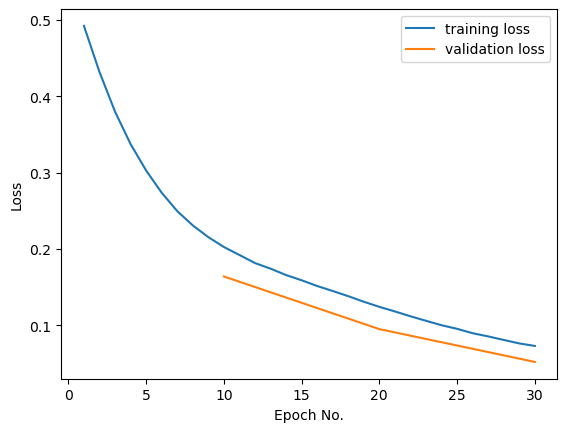

In [63]:
#plot loss as a function of epoch

epoch_range=np.arange(1,epoch_num + 1)

plt.plot(epoch_range, train_losses, label = 'training loss')
plt.plot(epoch_range[epoch_range % 10 == 0], val_losses, label = 'validation loss')

plt.legend()
plt.xlabel('Epoch No.')
plt.ylabel('Loss')

In [64]:
# Convert output to probabilities and get predictions
test_probs = torch.sigmoid(test_output) #converts output by model into probabilities
test_preds = torch.argmax(test_probs, dim=-1).squeeze() 

# Calculate metrics
accuracy = metrics.accuracy_score(flag_test, test_preds)
precision = metrics.precision_score(flag_test, test_preds)
recall = metrics.recall_score(flag_test, test_preds)
f1_score = metrics.f1_score(flag_test, test_preds)
# harmonic mean of precision and recall (1=best, 0=worst)

In [65]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Text(0.5, 1.0, 'CONFUSION MATRIX')

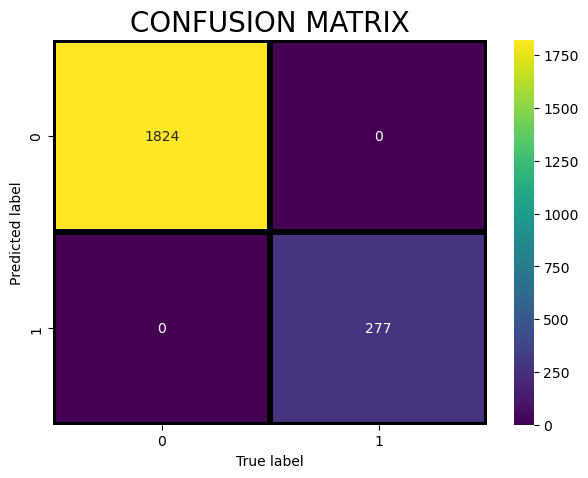

In [68]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(flag_test, test_preds),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("CONFUSION MATRIX",fontsize=20)